# Packages

In [1]:
# Data Processing and Analytics
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings 
# Machine Learning and ML Preprocessing
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
# Neural Networks
import tensorflow as tf
from tensorflow.keras.layers import Dense, Input, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.losses import SparseCategoricalCrossentropy, BinaryCrossentropy
from tensorflow.keras.regularizers import L2, L1
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
# Presets
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
warnings.filterwarnings('ignore')
%matplotlib inline

## Set Seed

In [2]:
np.random.seed(100)

# Import Data

In [3]:
data = pd.read_csv('data_for_ml.csv')
data.head(2)

,INDEX_,HOUR,DAYOFWEEK,VISIBILITY,LIGHT,RDSFCOND,TEMP,REL_HUMID,LOCCOORD,TRAFFCTL,ROADCLASS,SPEEDLMT,VEH_ADT,PED_ADT,LAND_USE,POP_2021,PRIV_DWELL,LAND_AREA,INVAGE,PEDCOND,PEDACT,VEHINV,VIOL,INJURY
0,3366652,7,weekday,Other,Dark,Wet,1.5,0.99,Midblock,No Control,Major Arterial,60,498.0,219.0,Mixed Use,504,263,225,45 to 64,Distracted,Crossing without ROW,automobile,speeding,Major
1,3370334,19,weekday,Rain,Dark,Wet,4.8,1.00,Midblock,Traffic Signal including Transit,Major Arterial,60,351.0,63.0,Residential,452,205,183,Over 65,Normal,Crossing without ROW,automobile,speeding,Major


In [4]:
df = data.drop('INDEX_', axis=1)
df.head(1)

,HOUR,DAYOFWEEK,VISIBILITY,LIGHT,RDSFCOND,TEMP,REL_HUMID,LOCCOORD,TRAFFCTL,ROADCLASS,SPEEDLMT,VEH_ADT,PED_ADT,LAND_USE,POP_2021,PRIV_DWELL,LAND_AREA,INVAGE,PEDCOND,PEDACT,VEHINV,VIOL,INJURY
0,7,weekday,Other,Dark,Wet,1.5,0.99,Midblock,No Control,Major Arterial,60,498.0,219.0,Mixed Use,504,263,225,45 to 64,Distracted,Crossing without ROW,automobile,speeding,Major


In [5]:
# Integer encode the INJURY column
injury_map = {
    'Fatal' : 4,
    'Major' : 3,
    'Minor' : 2,
    'Minimal' : 1,
    np.nan : 0
}
df['INJURY'] = df['INJURY'].replace(injury_map).astype(int)
df.head(1)

,HOUR,DAYOFWEEK,VISIBILITY,LIGHT,RDSFCOND,TEMP,REL_HUMID,LOCCOORD,TRAFFCTL,ROADCLASS,SPEEDLMT,VEH_ADT,PED_ADT,LAND_USE,POP_2021,PRIV_DWELL,LAND_AREA,INVAGE,PEDCOND,PEDACT,VEHINV,VIOL,INJURY
0,7,weekday,Other,Dark,Wet,1.5,0.99,Midblock,No Control,Major Arterial,60,498.0,219.0,Mixed Use,504,263,225,45 to 64,Distracted,Crossing without ROW,automobile,speeding,3


# ML Data Preprocessing

In [6]:
# Split into X and y variables
X = df.iloc[:, :-1].values
y = df.iloc[:,-1].values

In [7]:
# One hot encode the categorical columns
cat_columns_index = [1, 2, 3, 4, 7, 8, 9, 13, 17, 18, 19, 20, 21]
encoder = OneHotEncoder(categories='auto', sparse=False, handle_unknown='ignore')
X_cat = encoder.fit_transform(X[:, cat_columns_index])

In [17]:
# Combine the categorical and numerical columns
num_columns_index = [0, 5, 6, 10, 11, 12, 14, 15, 16]
X_encoded = np.concatenate((X_cat, X[:, num_columns_index].astype(float)), axis=1)
print(X_encoded)

[[1.000e+00 0.000e+00 0.000e+00 ... 5.040e+02 2.630e+02 2.250e+02]
 [1.000e+00 0.000e+00 0.000e+00 ... 4.520e+02 2.050e+02 1.830e+02]
 [1.000e+00 0.000e+00 1.000e+00 ... 8.070e+02 3.750e+02 3.220e+02]
 ...
 [1.000e+00 0.000e+00 0.000e+00 ... 4.820e+02 2.520e+02 2.310e+02]
 [0.000e+00 1.000e+00 1.000e+00 ... 1.981e+03 1.195e+03 1.112e+03]
 [1.000e+00 0.000e+00 1.000e+00 ... 1.170e+03 4.820e+02 4.670e+02]]


In [18]:
# Split encoded X and y to train test split
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.20, random_state=100)

In [19]:
# Scale the numerical features
scaler = StandardScaler()
X_train[:, -len(num_columns_index):] = scaler.fit_transform(X_train[:, -len(num_columns_index):])
X_test[:, -len(num_columns_index):] = scaler.transform(X_test[:, -len(num_columns_index):])
print(f"X_train dimension: {X_train.shape}")
print(f"y_train dimension: {y_train.shape}")
print(f"X_test dimension: {X_test.shape}")
print(f"y_test dimension: {y_test.shape}")

X_train dimension: (2490, 83)
y_train dimension: (2490,)
X_test dimension: (623, 83)
y_test dimension: (623,)


# ML Modeling and Metrics

In [11]:
models = [KNeighborsClassifier(), RandomForestClassifier(), XGBClassifier()]

In [12]:
# Define parameter grids
param_grid_knn = {
    'n_neighbors' : [i for i in range(1,36)],
    'weights' : ['uniform', 'distance'],
    'metric' : ['euclidean', 'manhattan']
}

param_grid_rf = {
    'n_estimators': [50, 100, 200],                
    'max_features': ['auto', 'sqrt', 'log2'],      
    'max_depth': [None, 10, 20, 30],               
    'min_samples_split': [2, 5, 10],               
    'min_samples_leaf': [1, 2, 4],                 
    'bootstrap': [True, False],                    
    'criterion': ['gini', 'entropy']               
}

param_grid_xgb = {
    'learning_rate': [0.01, 0.1, 0.3],
    'max_depth': [3, 5, 7],
    'min_child_weight': [1, 3, 5],
    'subsample': [0.5, 0.8, 1.0],
    'colsample_bytree': [0.5, 0.8, 1.0]
}

param_grids = [param_grid_knn, param_grid_rf, param_grid_xgb]

KNeighborsClassifier() Modeling Results:

Best Parameters:
{'weights': 'uniform', 'n_neighbors': 12, 'metric': 'manhattan'}

Training Accuracy: 77.95%
Testing Accuracy: 77.85%
Precision: 67.53%
Recall: 77.85%
F1 Score: 70.18%

Confusion Matrix:
[[  0   0   0   6   0]
 [  0   0   0  13   1]
 [  0   0   0  20   0]
 [  0   0   0 479   9]
 [  0   0   0  89   6]]

RandomForestClassifier() Modeling Results:

Best Parameters:
{'n_estimators': 100, 'min_samples_split': 10, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_depth': None, 'criterion': 'gini', 'bootstrap': True}

Training Accuracy: 77.83%
Testing Accuracy: 78.97%
Precision: 72.22%
Recall: 78.97%
F1 Score: 71.27%

Confusion Matrix:
[[  0   0   0   6   0]
 [  0   0   0  14   0]
 [  0   0   0  20   0]
 [  0   0   0 484   4]
 [  0   0   0  87   8]]

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping

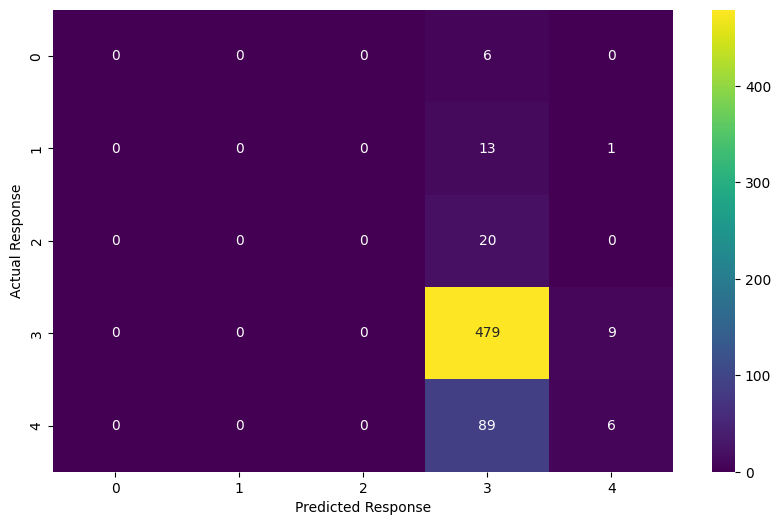

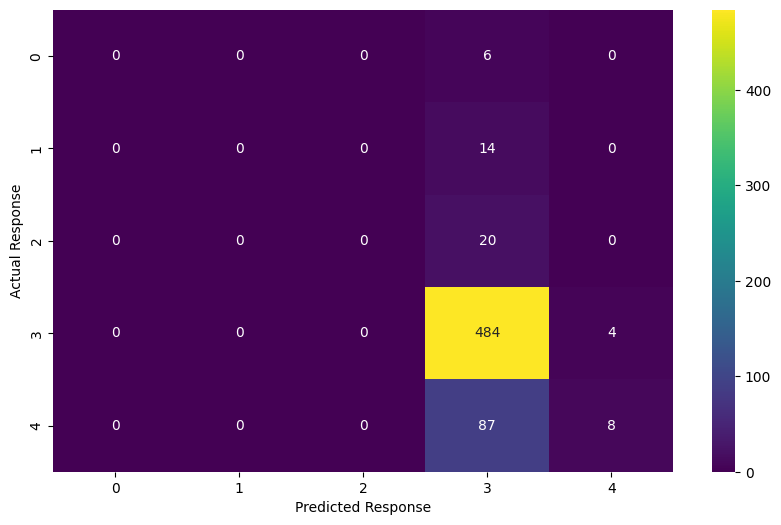

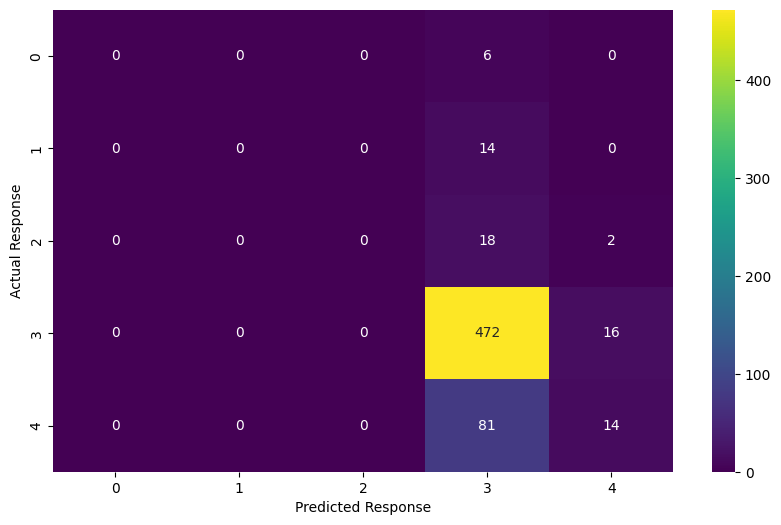

In [13]:
# Iterate on both grids and models to fit the model with our training data
for model, grid in zip(models, param_grids):
    random_search = RandomizedSearchCV(estimator=model,
                                      param_distributions=grid,
                                      n_iter=100,
                                      cv=5,
                                      scoring='accuracy',
                                      random_state=100)
    random_search.fit(X_train, y_train)
    y_pred = random_search.predict(X_test)
    training_accuracy = random_search.best_score_
    best_parameters = random_search.best_params_
    print(f'{model} Modeling Results:\n')
    print('Best Parameters:')
    print(f'{best_parameters}\n')
    print(f"Training Accuracy: {training_accuracy*100:.2f}%")
    print(f"Testing Accuracy: {accuracy_score(y_test, y_pred)*100:.2f}%")
    print(f"Precision: {precision_score(y_test, y_pred, average='weighted')*100:.2f}%")
    print(f"Recall: {recall_score(y_test, y_pred, average='weighted')*100:.2f}%")
    print(f"F1 Score: {f1_score(y_test, y_pred, average='weighted')*100:.2f}%\n")
    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    print(f"Confusion Matrix:")
    print(f"{cm}\n")
    plt.figure(figsize=(10,6))
    sns.heatmap(cm, annot=True, fmt='g', cmap='viridis')
    plt.xlabel('Predicted Response')
    plt.ylabel('Actual Response')

# Neural Network Modeling

In [14]:
tf.random.set_seed(100)

## Design 1 - 2 Hidden Layers

In [72]:
# Construct NN Architecture
design1 = Sequential([
    Dense(units=50, activation='relu', input_shape=(83,)),
    Dropout(rate=0.4),
    Dense(units=5, activation='linear', kernel_regularizer=L1(0.01))
])
# Compile the model
design1.compile(loss=SparseCategoricalCrossentropy(from_logits=True),
               optimizer=Adam(learning_rate=0.01),
               metrics=['accuracy'])
# Train the model
design1.fit(X_train, y_train, epochs=100, validation_data=[X_test, y_test])

Epoch 1/100
78/78 [==============================] - 1s 3ms/step - loss: 0.9382 - accuracy: 0.7655 - val_loss: 0.7614 - val_accuracy: 0.7817
Epoch 2/100
78/78 [==============================] - 0s 2ms/step - loss: 0.7487 - accuracy: 0.7767 - val_loss: 0.7423 - val_accuracy: 0.7769
Epoch 3/100
78/78 [==============================] - 0s 2ms/step - loss: 0.7398 - accuracy: 0.7767 - val_loss: 0.7315 - val_accuracy: 0.7753
Epoch 4/100
78/78 [==============================] - 0s 2ms/step - loss: 0.7316 - accuracy: 0.7739 - val_loss: 0.7291 - val_accuracy: 0.7833
Epoch 5/100
78/78 [==============================] - 0s 2ms/step - loss: 0.7129 - accuracy: 0.7803 - val_loss: 0.7278 - val_accuracy: 0.7817
Epoch 6/100
78/78 [==============================] - 0s 2ms/step - loss: 0.7011 - accuracy: 0.7847 - val_loss: 0.7312 - val_accuracy: 0.7833
Epoch 7/100
78/78 [==============================] - 0s 2ms/step - loss: 0.6933 - accuracy: 0.7791 - val_loss: 0.7217 - val_accuracy: 0.7833
Epoch 8/100
7

Epoch 59/100
78/78 [==============================] - 0s 2ms/step - loss: 0.6209 - accuracy: 0.8000 - val_loss: 0.7462 - val_accuracy: 0.7785
Epoch 60/100
78/78 [==============================] - 0s 2ms/step - loss: 0.6230 - accuracy: 0.8020 - val_loss: 0.7430 - val_accuracy: 0.7705
Epoch 61/100
78/78 [==============================] - 0s 2ms/step - loss: 0.6084 - accuracy: 0.8108 - val_loss: 0.7619 - val_accuracy: 0.7881
Epoch 62/100
78/78 [==============================] - 0s 2ms/step - loss: 0.6162 - accuracy: 0.8092 - val_loss: 0.7413 - val_accuracy: 0.7769
Epoch 63/100
78/78 [==============================] - 0s 2ms/step - loss: 0.6064 - accuracy: 0.8068 - val_loss: 0.7400 - val_accuracy: 0.7657
Epoch 64/100
78/78 [==============================] - 0s 2ms/step - loss: 0.6060 - accuracy: 0.8108 - val_loss: 0.7531 - val_accuracy: 0.7785
Epoch 65/100
78/78 [==============================] - 0s 2ms/step - loss: 0.6099 - accuracy: 0.8064 - val_loss: 0.7702 - val_accuracy: 0.7865
Epoch 

## Design 2 - 4 Hidden Layers

In [73]:
# Construct NN Architecture
design2 = Sequential([
    Dense(units=50, activation='relu', input_shape=(83,)),
    Dropout(rate=0.4),
    Dense(units=50, activation='relu'),
    Dropout(rate=0.4),
    Dense(units=5, activation='linear', kernel_regularizer=L1(0.01))
])
# Compile the model
design2.compile(loss=SparseCategoricalCrossentropy(from_logits=True),
               optimizer=Adam(learning_rate=0.01),
               metrics=['accuracy'])
# Train the model
design2.fit(X_train, y_train, epochs=100, validation_data=[X_test, y_test])

Epoch 1/100
78/78 [==============================] - 1s 3ms/step - loss: 0.9771 - accuracy: 0.7659 - val_loss: 0.7720 - val_accuracy: 0.7833
Epoch 2/100
78/78 [==============================] - 0s 2ms/step - loss: 0.7837 - accuracy: 0.7735 - val_loss: 0.7365 - val_accuracy: 0.7833
Epoch 3/100
78/78 [==============================] - 0s 2ms/step - loss: 0.7434 - accuracy: 0.7747 - val_loss: 0.7225 - val_accuracy: 0.7833
Epoch 4/100
78/78 [==============================] - 0s 2ms/step - loss: 0.7156 - accuracy: 0.7767 - val_loss: 0.7200 - val_accuracy: 0.7833
Epoch 5/100
78/78 [==============================] - 0s 2ms/step - loss: 0.7045 - accuracy: 0.7807 - val_loss: 0.7267 - val_accuracy: 0.7769
Epoch 6/100
78/78 [==============================] - 0s 2ms/step - loss: 0.6965 - accuracy: 0.7791 - val_loss: 0.7157 - val_accuracy: 0.7801
Epoch 7/100
78/78 [==============================] - 0s 2ms/step - loss: 0.6739 - accuracy: 0.7847 - val_loss: 0.7088 - val_accuracy: 0.7849
Epoch 8/100
7

Epoch 59/100
78/78 [==============================] - 0s 3ms/step - loss: 0.5307 - accuracy: 0.8277 - val_loss: 0.9360 - val_accuracy: 0.7432
Epoch 60/100
78/78 [==============================] - 0s 2ms/step - loss: 0.5304 - accuracy: 0.8337 - val_loss: 0.9037 - val_accuracy: 0.7753
Epoch 61/100
78/78 [==============================] - 0s 2ms/step - loss: 0.5292 - accuracy: 0.8386 - val_loss: 0.9228 - val_accuracy: 0.7769
Epoch 62/100
78/78 [==============================] - 0s 2ms/step - loss: 0.5391 - accuracy: 0.8301 - val_loss: 0.9702 - val_accuracy: 0.7544
Epoch 63/100
78/78 [==============================] - 0s 2ms/step - loss: 0.5212 - accuracy: 0.8361 - val_loss: 0.9359 - val_accuracy: 0.7640
Epoch 64/100
78/78 [==============================] - 0s 2ms/step - loss: 0.5262 - accuracy: 0.8289 - val_loss: 0.8890 - val_accuracy: 0.7737
Epoch 65/100
78/78 [==============================] - 0s 2ms/step - loss: 0.5163 - accuracy: 0.8301 - val_loss: 1.0838 - val_accuracy: 0.7624
Epoch 

## Design 3 - 6 Hidden Layers

In [74]:
# Construct NN Architecture
design3 = Sequential([
    Dense(units=50, activation='relu', input_shape=(83,)),
    Dropout(rate=0.4),
    Dense(units=50, activation='relu'),
    Dropout(rate=0.4),
    Dense(units=50, activation='relu'),
    Dropout(rate=0.4),
    Dense(units=5, activation='linear', kernel_regularizer=L1(0.01))
])
# Compile the model
design3.compile(loss=SparseCategoricalCrossentropy(from_logits=True),
               optimizer=Adam(learning_rate=0.01),
               metrics=['accuracy'])
# Train the model
design3.fit(X_train, y_train, epochs=100, validation_data=[X_test, y_test])

Epoch 1/100
78/78 [==============================] - 1s 4ms/step - loss: 1.0190 - accuracy: 0.7618 - val_loss: 0.8114 - val_accuracy: 0.7833
Epoch 2/100
78/78 [==============================] - 0s 2ms/step - loss: 0.7961 - accuracy: 0.7763 - val_loss: 0.7700 - val_accuracy: 0.7833
Epoch 3/100
78/78 [==============================] - 0s 2ms/step - loss: 0.7679 - accuracy: 0.7739 - val_loss: 0.7403 - val_accuracy: 0.7833
Epoch 4/100
78/78 [==============================] - 0s 2ms/step - loss: 0.7528 - accuracy: 0.7791 - val_loss: 0.7249 - val_accuracy: 0.7833
Epoch 5/100
78/78 [==============================] - 0s 2ms/step - loss: 0.7129 - accuracy: 0.7815 - val_loss: 0.7328 - val_accuracy: 0.7801
Epoch 6/100
78/78 [==============================] - 0s 2ms/step - loss: 0.7048 - accuracy: 0.7771 - val_loss: 0.7202 - val_accuracy: 0.7833
Epoch 7/100
78/78 [==============================] - 0s 2ms/step - loss: 0.7034 - accuracy: 0.7751 - val_loss: 0.7054 - val_accuracy: 0.7817
Epoch 8/100
7

Epoch 59/100
78/78 [==============================] - 0s 2ms/step - loss: 0.5558 - accuracy: 0.8281 - val_loss: 0.9866 - val_accuracy: 0.7753
Epoch 60/100
78/78 [==============================] - 0s 2ms/step - loss: 0.5571 - accuracy: 0.8241 - val_loss: 0.9855 - val_accuracy: 0.7833
Epoch 61/100
78/78 [==============================] - 0s 2ms/step - loss: 0.5727 - accuracy: 0.8277 - val_loss: 0.9662 - val_accuracy: 0.7849
Epoch 62/100
78/78 [==============================] - 0s 2ms/step - loss: 0.5536 - accuracy: 0.8217 - val_loss: 0.9594 - val_accuracy: 0.7769
Epoch 63/100
78/78 [==============================] - 0s 3ms/step - loss: 0.5577 - accuracy: 0.8233 - val_loss: 0.9718 - val_accuracy: 0.7801
Epoch 64/100
78/78 [==============================] - 0s 3ms/step - loss: 0.5577 - accuracy: 0.8249 - val_loss: 0.9910 - val_accuracy: 0.7785
Epoch 65/100
78/78 [==============================] - 0s 3ms/step - loss: 0.5382 - accuracy: 0.8293 - val_loss: 1.0376 - val_accuracy: 0.7801
Epoch 

# NN Performance Metrics

In [75]:
models = [design1, design2, design3]
for model in models:
    y_pred = model.predict(X_test)
    y_pred_classes = np.argmax(y_pred, axis=1)
    train_loss, train_accuracy = model.evaluate(X_train, y_train)
    test_loss, test_accuracy = model.evaluate(X_test, y_test)
    precision = precision_score(y_test, y_pred_classes, average='weighted')
    recall = recall_score(y_test, y_pred_classes, average='weighted')
    f1 = f1_score(y_test, y_pred_classes, average='weighted')
    print(f"Model Performance Metrics:")
    print(f"Training Accuracy: {train_accuracy*100:.2f}%")
    print(f"Test Accuracy: {test_accuracy*100:.2f}%")
    print(f"Precision: {precision*100:.2f}%")
    print(f"Recall: {recall*100:.2f}%")
    print(f"F1 Score: {f1*100:.2f}%\n")
    print(f"Confusion Matrix:")
    print(f"{confusion_matrix(y_test, y_pred_classes)}\n")

20/20 [==============================] - 0s 2ms/step - loss: 0.7575 - accuracy: 0.7737
Model Performance Metrics:
Training Accuracy: 84.10%
Test Accuracy: 77.37%
Precision: 69.16%
Recall: 77.37%
F1 Score: 72.10%

Confusion Matrix:
[[  0   0   0   6   0]
 [  0   0   0  14   0]
 [  0   1   0  18   1]
 [  0   0   0 464  24]
 [  0   0   0  77  18]]

20/20 [==============================] - 0s 2ms/step - loss: 1.1771 - accuracy: 0.7624
Model Performance Metrics:
Training Accuracy: 88.11%
Test Accuracy: 76.24%
Precision: 69.65%
Recall: 76.24%
F1 Score: 72.65%

Confusion Matrix:
[[  0   0   0   6   0]
 [  0   0   0  12   2]
 [  0   0   0  18   2]
 [  0   0   0 446  42]
 [  0   0   0  66  29]]

20/20 [==============================] - 0s 2ms/step - loss: 1.4741 - accuracy: 0.7737
Model Performance Metrics:
Training Accuracy: 86.51%
Test Accuracy: 77.37%
Precision: 69.54%
Recall: 77.37%
F1 Score: 72.65%

Confusion Matrix:
[[  0   0   0   6   0]
 [  0   0   0  13   1]
 [  0   0   0  18   2]
 [  